<a href="https://colab.research.google.com/github/HerbertMariano/classificacao_genero/blob/master/text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2>Análise de Gênero de Autores:</h2>
    <li>Fazer um experimento de classificação de texto e utilizar as métricas de classificação
    <li>Quem escreve mais páginas, homens ou mulheres ou não há diferença? (Fazer um gráfico)
    <li>Como é a distribuição de gênero de livro para homens e mulheres? (Fazer um gráfico)
    <li>Com todos os atributos, fazer um experimento para identificar gênero do autor. Não utilize a coluna gênero do autor nem nome do autor nem id do autor como atributo.
    <li>Fazer alguma visualização com wordcloud

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import warnings
warnings.filterwarnings('ignore')

In [88]:
df = pd.read_csv('https://raw.githubusercontent.com/HerbertMariano/classificacao_genero/master/good_reads_final.csv')

In [89]:
df.columns

Index(['author_average_rating', 'author_gender', 'author_genres', 'author_id',
       'author_name', 'author_page_url', 'author_rating_count',
       'author_review_count', 'birthplace', 'book_average_rating',
       'book_fullurl', 'book_id', 'book_title', 'genre_1', 'genre_2',
       'num_ratings', 'num_reviews', 'pages', 'publish_date', 'score'],
      dtype='object')

<h2>Limpando os Dados

In [90]:
df.drop(columns=['book_fullurl','author_page_url'], inplace=True)

In [91]:
df['pages'] = np.where(df['pages'] == '1 page', 1, df['pages'])
df['birthplace'] = df['birthplace'].str.replace('\\n', '')
df['author_name'] = df['author_name'].str.replace('\\n', '')
df['book_title'] = df['book_title'].str.replace('\\n', '')
df.publish_date = df.publish_date.str.extract('(^[\d]{1,4})').astype('category')

In [92]:
df['author_average_rating'] = df['author_average_rating'].astype(float)
df['author_gender'] = df['author_gender'].astype(str).astype('category')
df['author_genres'] = df['author_genres'].astype(str).astype('category')
df['author_id'] = df['author_id'].astype(int).astype('category')
df['author_name'] = df['author_name'].astype(str)
df['author_rating_count'] = df['author_rating_count'].astype(int)
df['author_review_count'] = df['author_review_count'].astype(int)
df['book_id'] = df['book_id'].astype(str).astype('category')
df['birthplace'] = df['birthplace'].astype(str)
df['book_average_rating'] = df['book_average_rating'].astype(float)
df['book_title'] = df['book_title'].astype(str)
df['genre_1'] = df['genre_1'].astype(str).astype('category')
df['genre_2'] = df['genre_2'].astype(str).astype('category')
df['num_ratings'] = df['num_ratings'].astype(int)
df['num_reviews'] = df['num_reviews'].astype(int)
df['pages'] = df['pages'].astype(int)
df['score'] = df['score'].astype(float)

In [93]:
df.head()

,author_average_rating,author_gender,author_genres,author_id,author_name,author_rating_count,author_review_count,birthplace,book_average_rating,book_id,book_title,genre_1,genre_2,num_ratings,num_reviews,pages,publish_date,score
0,4.01,female,"historical-fiction,",74489,Victoria Thompson,74399,6268,United States,4.02,686717,Murder on St. Mark's Place,Mystery,Historical,5260,375,277,2000,3230.0
1,4.15,male,"literature-fiction,mystery-thrillers,",706255,Stieg Larsson,3726435,142704,Sweden,4.13,2429135,The Girl with the Dragon Tattoo,Fiction,Mystery,2229163,65227,465,NaN,3062.0
2,4.00,female,"romance,",5618190,Mimi Jean Pamfiloff,76496,7975,United States,3.99,27833684,Tailored for Trouble,Romance,Contemporary,2151,391,354,2016,4585.0
3,3.88,male,"fiction,memoir,",37871,José Donoso,5522,489,Chile,4.14,382975,The Obscene Bird of Night,Fiction,Magical Realism,1844,173,438,1970,1533.0
4,4.10,female,"young-adult,fantasy,",36122,Patricia C. Wrede,291013,13453,United States,4.01,64207,Sorcery & Cecelia: or The Enchanted Choc...,Fantasy,Young Adult,17051,1890,326,NaN,2105.0


Text(0.5, 1.0, 'Total de páginas por gênero')

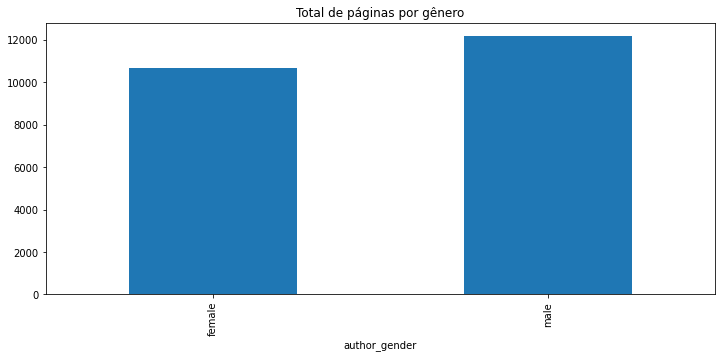

In [94]:
df.groupby('author_gender',observed=True).count()['pages'].plot(kind='bar',figsize=(12,5)).set_title('Total de páginas por gênero')

([], [])

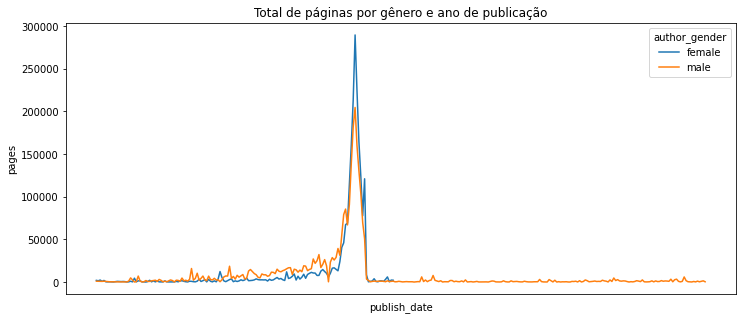

In [95]:
plt.figure(figsize=(12,5))
sns.lineplot(data=df.dropna().groupby(['author_gender','publish_date'],observed=True,as_index=True).sum(),x='publish_date',y='pages',hue='author_gender').set_title('Total de páginas por gênero e ano de publicação')
plt.xticks([])

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123]),
 [Text(0, 0, 'Adult'),
  Text(1, 0, 'Adult Fiction'),
  Text(2, 0, 'Adventure'),
  Text(3, 0, 'Amish'),
  Text(4, 0, 'Animals'),
  Text(5, 0, 'Anthologies'),
  Text(6, 0, 'Apocalyptic'),
  Text(7, 0, 'Art'),
  Text(8, 0, 'Asian Literature'),
  Text(9, 0, 'Autobiography'),
  Text(10, 0, 'Biblical F

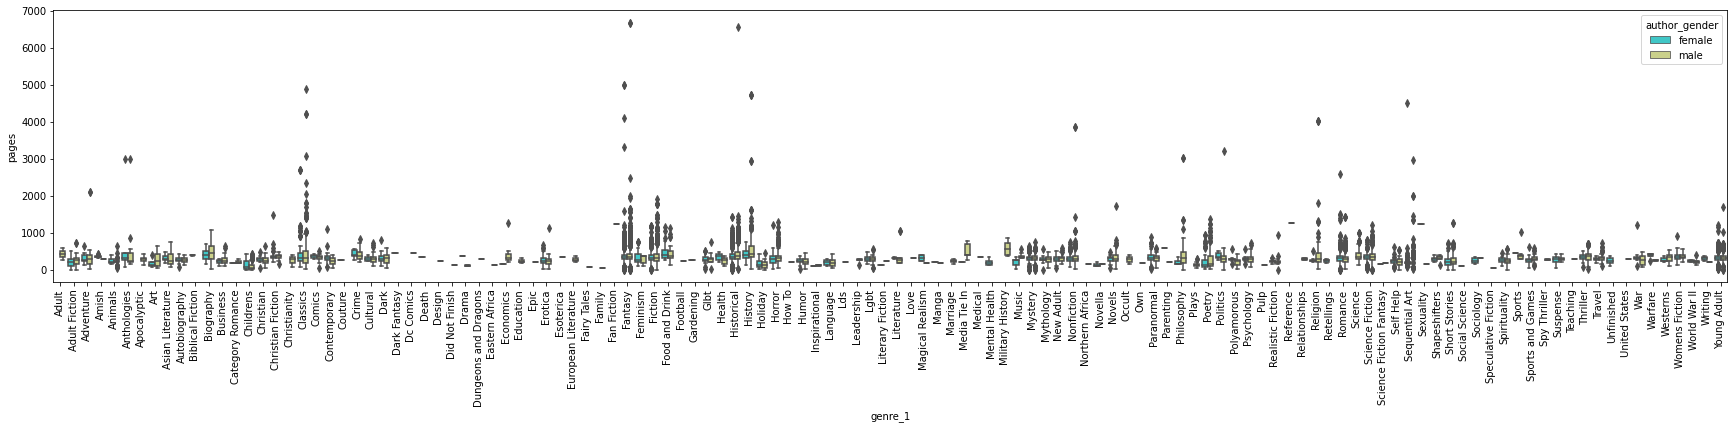

In [96]:
plt.figure(figsize=(30,5))
sns.boxplot(x='genre_1',y='pages',data=df,hue='author_gender', palette='rainbow')
plt.xticks(rotation=90)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156]),
 [Text(0, 0, 'Academic'),
  Text(1, 0, 'Action'),
  Text(2, 0, 'Adult'),
  Text(3, 0, 'Adult Fiction'),
  Tex

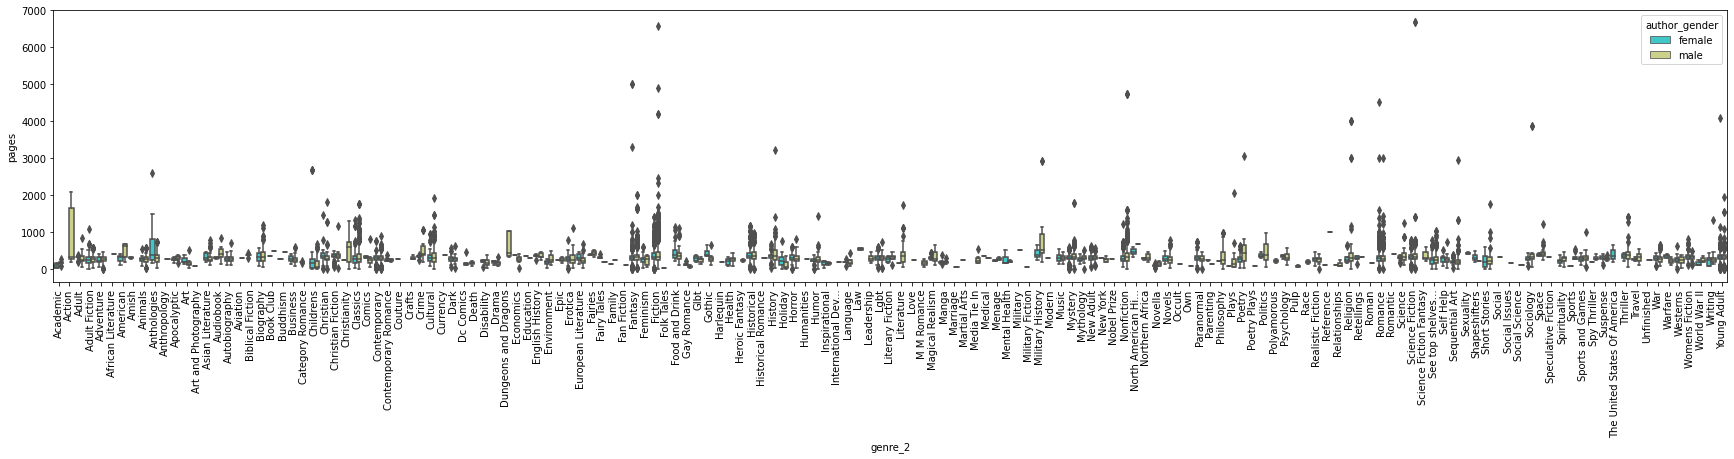

In [97]:
plt.figure(figsize=(30,5))
sns.boxplot(x='genre_2',y='pages',data=df,hue='author_gender', palette='rainbow')
plt.xticks(rotation=90)

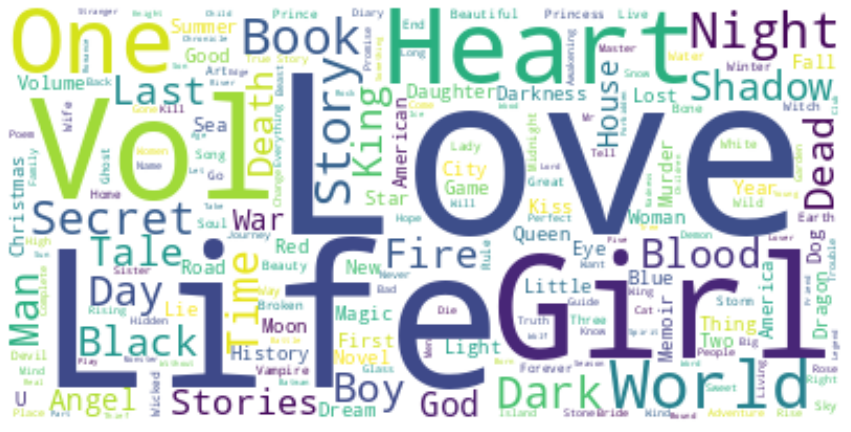

In [98]:
text = " ".join(i for i in df['book_title'])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [99]:
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

In [100]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['genre_1'])


In [101]:
X_train, X_test, y_train, y_test = train_test_split(df['book_title'], df['target'], test_size=0.2, random_state=42)

In [102]:
def preprocess_text(text):
    return [token for token in simple_preprocess(remove_stopwords(text)) if token not in ['']]

In [103]:
train_data = [preprocess_text(text) for text in X_train]
test_data = [preprocess_text(text) for text in X_test]

In [104]:
print(train_data[0], y_train.iloc[0])
print(test_data[0], y_test.iloc[0])

['practice', 'makes', 'perfect'] 95
['lush', 'life'] 44


In [105]:
train_tagged = [TaggedDocument(words=doc, tags=[str(i)]) for i, doc in enumerate(train_data)]
test_tagged = [TaggedDocument(words=doc, tags=[str(i)]) for i, doc in enumerate(test_data)]

In [106]:
print(train_tagged[0], y_train.iloc[0])
print(test_tagged[0], y_test.iloc[0])

TaggedDocument(['practice', 'makes', 'perfect'], ['0']) 95
TaggedDocument(['lush', 'life'], ['0']) 44


In [107]:
model = Doc2Vec(vector_size=50, min_count=2, epochs=40)
model.build_vocab(train_tagged)
model.train(train_tagged, total_examples=model.corpus_count, epochs=model.epochs)

In [108]:
train_vectors = [model.infer_vector(doc.words) for doc in train_tagged]
test_vectors = [model.infer_vector(doc.words) for doc in test_tagged]

In [109]:
print(train_vectors[0], y_train.iloc[0])
print(test_vectors[0], y_test.iloc[0])

[-9.24597904e-02 -5.77467456e-02  4.33193706e-02 -3.82627286e-02
  5.26798666e-02 -1.00459516e-01  4.67889681e-02  4.97867838e-02
 -8.73045716e-03 -1.49294913e-01  2.02972889e-02  2.04445291e-02
 -1.94169562e-02  2.99756303e-02  7.73021951e-02 -7.43100718e-02
  1.69815248e-04  1.70943424e-01  4.14552093e-02 -7.99597241e-03
  1.36068054e-02 -2.78880261e-02 -1.82374194e-01 -8.57627913e-02
 -1.29263520e-01 -9.11450610e-02 -6.91551343e-02 -3.76384817e-02
  3.26870009e-04  9.62719880e-03 -8.81096497e-02 -2.98041254e-02
  2.74387803e-02  5.47446422e-02  5.49303852e-02 -6.91217836e-03
  2.56984588e-02  7.27239007e-04 -5.02002351e-02 -1.06934838e-01
  1.87049940e-01  1.68346927e-01 -5.35094179e-02  6.08242825e-02
  5.79449497e-02  1.41009688e-01  7.35753030e-02  5.90737537e-02
 -5.77106811e-02  6.71174452e-02] 95
[-0.11390451 -0.072504    0.11433852  0.0452345  -0.06329862 -0.0195312
 -0.00502083  0.04950797 -0.0129469  -0.03431638 -0.1185946   0.11857301
 -0.04729664  0.05685743  0.02686521 -

<h3>Tuning

In [110]:
param_space = {
    "LogisticRegression": {
        "classifier": [LogisticRegression()],
        "classifier__C": np.logspace(-4, 4, 20),
        "classifier__penalty": ["l1", "l2", "elasticnet", "none"],
        "classifier__solver": ["lbfgs", "liblinear", "saga"]
    },
    "KNeighborsClassifier": {
        "classifier": [KNeighborsClassifier()],
        "classifier__n_neighbors": range(1, 31),
        "classifier__weights": ["uniform", "distance"],
        "classifier__algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
        "classifier__leaf_size": range(1, 51)
    },
    "DecisionTreeClassifier": {
        "classifier": [DecisionTreeClassifier()],
        "classifier__max_depth": range(1, 31),
        "classifier__criterion": ["gini", "entropy"],
        "classifier__splitter": ["best", "random"]
    },
    "RandomForestClassifier": {
        "classifier": [RandomForestClassifier()],
        "classifier__n_estimators": range(10, 101, 10),
        "classifier__criterion": ["gini", "entropy"],
        "classifier__max_depth": range(1, 31),
        "classifier__min_samples_split": range(2, 11),
        "classifier__min_samples_leaf": range(1, 6),
        "classifier__bootstrap": [True, False]
    },
    "GradientBoostingClassifier": {
        "classifier": [GradientBoostingClassifier()],
        "classifier__n_estimators": range(10, 101, 10),
        "classifier__learning_rate": np.logspace(-4, 0, 10),
        "classifier__max_depth": range(1, 31),
        "classifier__min_samples_split": range(2, 11),
        "classifier__min_samples_leaf": range(1, 6),
        "classifier__subsample": np.arange(0.5, 1.0, 0.1)
    },
    "SVC": {
        "classifier": [SVC()],
        "classifier__C": np.logspace(-4, 4, 20),
        "classifier__kernel": ["linear", "rbf", "poly", "sigmoid"],
"classifier__degree": range(1, 6),
"classifier__gamma": ["scale", "auto"]
}
}   


<h3>Models

In [111]:
classifiers = [
LogisticRegression(),
KNeighborsClassifier(),
DecisionTreeClassifier(),
RandomForestClassifier(),
GradientBoostingClassifier(),
SVC(),
]

In [112]:
results = []
for clf in classifiers:
    pipe = Pipeline([('classifier', clf)])

In [113]:
random_search = RandomizedSearchCV(pipe, param_space[clf.__class__.__name__], n_iter=5, cv=2, n_jobs=-1, random_state=42)
random_search.fit(train_vectors, y_train)

RandomizedSearchCV(cv=2, estimator=Pipeline(steps=[('classifier', SVC())]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'classifier': [SVC(C=1.623776739188721,
                                                           degree=5,
                                                           kernel='sigmoid')],
                                        'classifier__C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'classifier__degree': range(1, 6),
                                        'classifier__gamma': ['scale', 'auto'],
                                        'classifier__kernel': ['linear', 'rbf',
       

In [114]:
y_pred = random_search.predict(test_vectors)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred,average='weighted')
f1 = f1_score(y_test,y_pred,average='weighted')
precision = precision_score(y_test,y_pred,average='weighted')
results.append({
    "model": clf.__class__.__name__,
    "best_params": random_search.best_params_,
    "accuracy": accuracy,
    "recall": recall,
    "precision":precision,
    "f1_score":f1
})

In [116]:
for result in results:
    print("Model:", result["model"])
    print("Best params:", result["best_params"])
    print("Accuracy:", result["accuracy"])
    print("F1_score:", result["f1_score"])
    print("Precision:", result["precision"])
    print("Recall:", result["recall"])
    print()

Model: SVC
Best params: {'classifier__kernel': 'sigmoid', 'classifier__gamma': 'scale', 'classifier__degree': 5, 'classifier__C': 1.623776739188721, 'classifier': SVC(C=1.623776739188721, degree=5, kernel='sigmoid')}
Accuracy: 0.15068792312732038
F1_score: 0.10910008115355196
Precision: 0.13753946476259915
Recall: 0.15068792312732038

